In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GAE, GCNConv

# Load datasets
labeled_data = pd.read_csv('3k_labeled_extracted.csv')
unlabeled_data = pd.read_csv('30k_unlabeled_extracted.csv')

# Prepare features and labels for labeled data
X_labeled = labeled_data.drop(columns=['text_', 'label']).values
y_labeled = labeled_data['label'].values

# For unlabeled data, use only features
X_unlabeled = unlabeled_data.drop(columns=['text_']).values

# Encode labels (e.g., 'CG' as 0, 'OR' as 1)
label_encoder = LabelEncoder()
y_labeled_encoded = label_encoder.fit_transform(y_labeled)

# Concatenate both datasets for graph creation
X_combined = np.vstack((X_labeled, X_unlabeled))

from sklearn.neighbors import kneighbors_graph

def create_graph(X, n_neighbors=5):
    # Create a knearest neighbor graph
    adj_matrix = kneighbors_graph(X, n_neighbors=n_neighbors, mode='connectivity', include_self=False)
    edge_index = torch.tensor(np.array(adj_matrix.nonzero()), dtype=torch.long)
    x = torch.tensor(X, dtype=torch.float)
    return Data(x=x, edge_index=edge_index)

# Create graph data for labeled and unlabeled datasets
graph_data = create_graph(X_combined, n_neighbors=5)

In [31]:
class GCN(torch.nn.Module):
    def __init__(self, input_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, 16)
        self.conv2 = GCNConv(16, 8)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

    def decode(self, z, edge_index):
        return torch.sigmoid(torch.matmul(z[edge_index[0]], z[edge_index[1]].T))

# Instantiate model
model = GCN(input_dim=X_combined.shape[1])

In [35]:
import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time

# Set the device to CPU
device = torch.device('cpu')

def train_gae(model, data, epochs=50, lr=0.01, early_stopping_patience=5, log_frequency=2):
    # Move model to CPU
    model.to(device)
    
    optimizer = Adam(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)  # Scheduler for LR
    best_loss = float('inf')
    patience_counter = 0
    loss_history = []  # To store the loss for calculating average loss

    model.train()
    start_time = time.time()  # Timing for monitoring

    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # Forward pass
        z = model.encode(data.x.to(device), data.edge_index.to(device))  # Ensure data is on CPU
        loss = model.decode(z, data.edge_index.to(device)).mean()

        # Backward pass
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        # Log loss at specified intervals
        loss_history.append(loss.item())
        if epoch % log_frequency == 0:
            avg_loss = sum(loss_history[-log_frequency:]) / min(len(loss_history), log_frequency)
            print(f'Epoch {epoch}: Loss {loss.item():.4f}, Avg Loss (last {log_frequency}): {avg_loss:.4f}')

        # Early stopping check
        if loss < best_loss:
            best_loss = loss
            patience_counter = 0  # Reset counter if we improved
        else:
            patience_counter += 1
            # Check if patience limit is reached
            if patience_counter >= early_stopping_patience:
                print("Early stopping triggered.")
                break
        
        # Step the scheduler
        scheduler.step(loss)

    end_time = time.time()
    print(f"Training completed in {end_time - start_time:.2f} seconds.")

# Train the model with the CPU
train_gae(model, graph_data)

/opt/anaconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 0: Loss 0.9466, Avg Loss (last 2): 0.9466
Epoch 2: Loss 0.7856, Avg Loss (last 2): 0.8228
Epoch 4: Loss 0.6801, Avg Loss (last 2): 0.7033
Epoch 6: Loss 0.6170, Avg Loss (last 2): 0.6306
Epoch 8: Loss 0.5841, Avg Loss (last 2): 0.5905
Epoch 10: Loss 0.5739, Avg Loss (last 2): 0.5753
Epoch 12: Loss 0.5670, Avg Loss (last 2): 0.5691
Epoch 14: Loss 0.5522, Avg Loss (last 2): 0.5565
Epoch 16: Loss 0.5340, Avg Loss (last 2): 0.5385
Epoch 18: Loss 0.5163, Avg Loss (last 2): 0.5205
Epoch 20: Loss 0.5051, Avg Loss (last 2): 0.5076
Epoch 22: Loss 0.5005, Avg Loss (last 2): 0.5009
Epoch 24: Loss 0.5056, Avg Loss (last 2): 0.5038
Epoch 26: Loss 0.5066, Avg Loss (last 2): 0.5074


KeyboardInterrupt: 

In [85]:
# Save the model state after training
torch.save(model.state_dict(), '26epochs_final_model_checkpoint.pth')
print("Model state saved to '26epochs_final_model_checkpoint.pth' ")

Model state saved to '26epochs_final_model_checkpoint.pth' 


In [21]:
# Step 1: Extract embeddings for unlabeled data using the same graph model
with torch.no_grad():
    num_labeled = len(y_labeled_encoded)
    all_embeddings = model.encode(
        graph_data.x.to(device), 
        graph_data.edge_index.to(device)  # Use the full edge_index
    ).cpu().numpy()
labeled_embeddings = all_embeddings[:num_labeled]
unlabeled_embeddings = all_embeddings[num_labeled:]
unlabeled_predictions = classifier.predict(unlabeled_embeddings)
unlabeled_data['predicted_label'] = label_encoder.inverse_transform(unlabeled_predictions)
# unlabeled_data.to_csv('2_unlabeled_with_predictions.csv', index=False)

# Print out some of the predictions for verification
print(unlabeled_data[['text_', 'predicted_label']].head())

NameError: name 'classifier' is not defined

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Random Forest Accuracy: 0.9090
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      1484
           1       0.92      0.90      0.91      1516

    accuracy                           0.91      3000
   macro avg       0.91      0.91      0.91      3000
weighted avg       0.91      0.91      0.91      3000

Precision: 0.9092
Recall: 0.9090
F1 Score: 0.9090

Random Forest Predicted Labels with Reviews (Head):
  Predicted Labels                                             Review
0               CG                                              NOTE:
1               OR  Very bad experience with this iPhone xr phone....
2               CG  Amazing phone with amazing camera coming from ...
3               OR  So I got the iPhone XR just today. The product...
4               OR  I've been an android user all my life until I ...


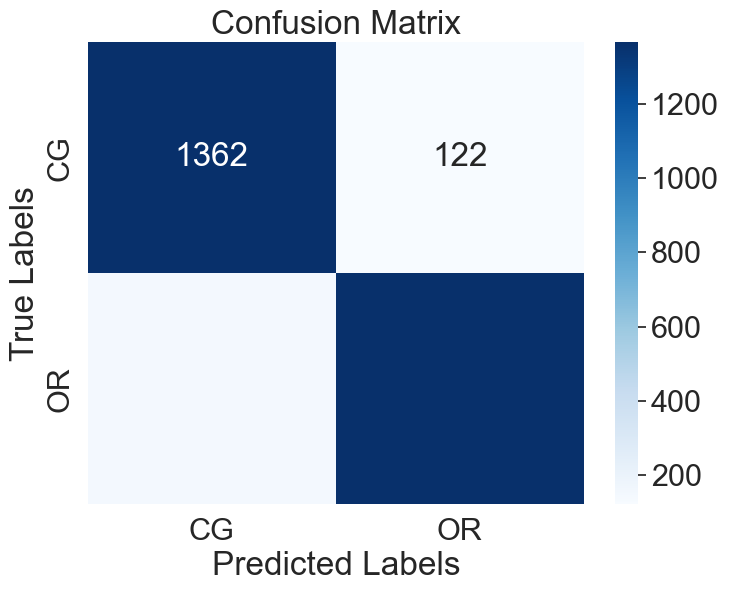


Best Parameters for Random Forest: {'max_depth': 10, 'n_estimators': 100}


In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (classification_report, accuracy_score, 
                             confusion_matrix, precision_score, recall_score, f1_score)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Step 1: Extract embeddings for the combined dataset (labeled + unlabeled)
def get_embeddings(model, data):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        z = model.encode(data.x.to(device), data.edge_index.to(device))
    return z.cpu().numpy()  # Move to CPU and convert to numpy array

# Get embeddings for the combined dataset (both labeled and unlabeled)
combined_embeddings = get_embeddings(model, graph_data)

# Split embeddings back into labeled and unlabeled parts
n_labeled = len(X_labeled)  # Number of labeled samples (3000 in your case)
labeled_embeddings = combined_embeddings[:n_labeled]  # First 3000 embeddings are for labeled data
unlabeled_embeddings = combined_embeddings[n_labeled:]  # Remaining embeddings are for unlabeled data

# Step 2: Train the Random Forest classifier on labeled embeddings
X_train = labeled_embeddings  # Labeled embeddings (3000 samples)
y_train = y_labeled_encoded  # Corresponding labels (3000 samples)

# Scale features for better performance in Random Forest
scaler = StandardScaler()

# Tune parameters for Random Forest
param_grid_rf = {'n_estimators': [100, 200], 'max_depth': [5, 10, None]}

# Initialize GridSearchCV for Random Forest
grid_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=3, scoring='accuracy', verbose=1)

# Step 3: Fit the classifier and compare results
pipeline = Pipeline([
    ('scaler', scaler),  # Add scaling
    ('classifier', grid_rf)  # Use tuned Random Forest
])

pipeline.fit(X_train, y_train)

# Evaluate on the training set
y_train_pred = pipeline.predict(X_train)

# Accuracy
acc = accuracy_score(y_train, y_train_pred)
print(f"Random Forest Accuracy: {acc:.4f}")

# Classification report
print(f"Random Forest Classification Report:\n{classification_report(y_train, y_train_pred)}")

# Calculate additional metrics
precision = precision_score(y_train, y_train_pred, average='weighted')
recall = recall_score(y_train, y_train_pred, average='weighted')
f1 = f1_score(y_train, y_train_pred, average='weighted')

# Print additional metrics
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Step 4: Predict labels for the unlabeled data
y_pred = pipeline.predict(unlabeled_embeddings)
predicted_labels = label_encoder.inverse_transform(y_pred)

# Prepare and display the predicted labels with corresponding reviews
unlabeled_reviews = pd.read_csv('30k_unlabeled_extracted.csv')['text_']  # Load and extract reviews from original file
predicted_labels_df = pd.DataFrame(predicted_labels, columns=['Predicted Labels'])
predicted_labels_df['Review'] = unlabeled_reviews  # Add the review text to the DataFrame

# Display the head of the predicted labels along with reviews
print(f"\nRandom Forest Predicted Labels with Reviews (Head):")
print(predicted_labels_df.head())

# Optional: Save predicted labels along with reviews to CSV
predicted_labels_df.to_csv('predicted_labels_unlabeled_with_reviews.csv', index=False)

# Plot confusion matrix
conf_matrix = confusion_matrix(y_train, y_train_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Optional: Compare final model's performance
print(f"\nBest Parameters for Random Forest: {grid_rf.best_params_}")


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score: 0.0062
Davies-Bouldin Index: 8.9122
Adjusted Rand Index: -0.0001


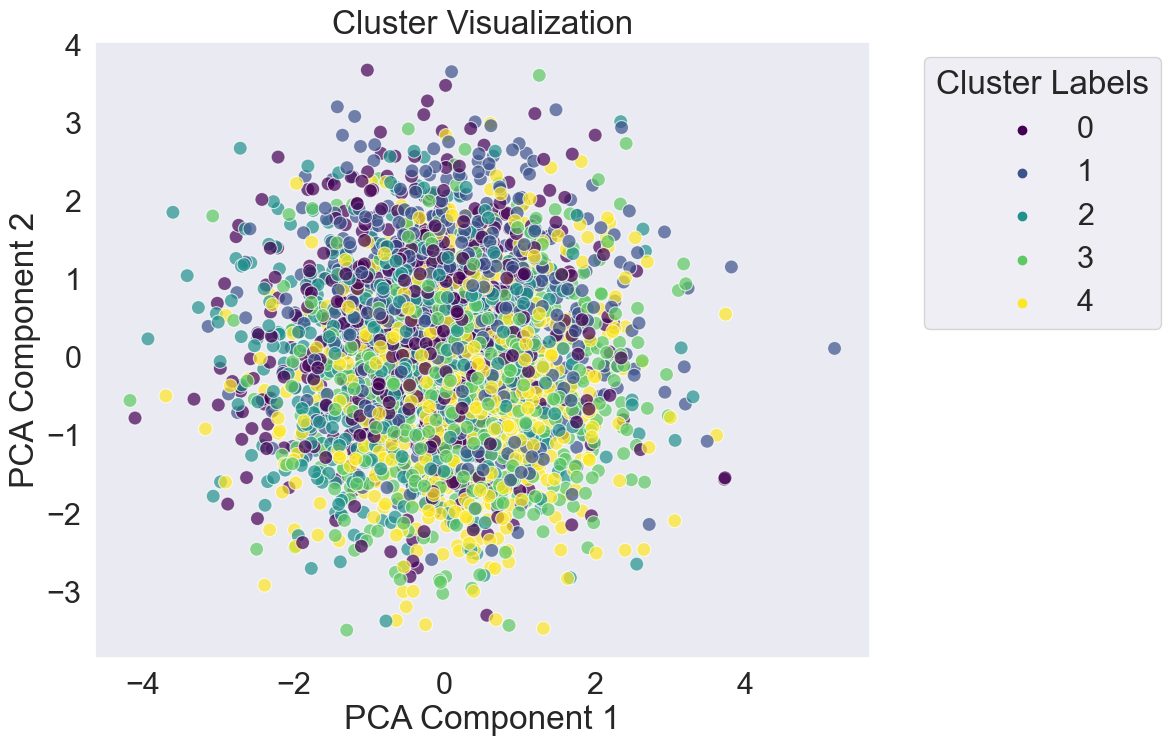

In [89]:
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Step 1: Load your embeddings or data
# Assume `embeddings` is a numpy array of shape (n_samples, n_features)
# For example, from a semi-supervised approach using a model like Graph Neural Network
# embeddings = np.load('your_embeddings.npy')

# Here is a mock example of how you might have your data
# This is just for illustrative purposes; replace with your actual data loading
n_samples = 3000  # Replace with your sample size
n_features = 128  # Replace with your feature size
np.random.seed(42)
embeddings = np.random.rand(n_samples, n_features)

# Step 2: Standardize the features
scaler = StandardScaler()
scaled_embeddings = scaler.fit_transform(embeddings)

# Step 3: Fit the clustering model (e.g., KMeans)
n_clusters = 5  # Specify the number of clusters you expect
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(scaled_embeddings)

# Step 4: Evaluate the clustering performance

# Calculate silhouette score
silhouette_avg = silhouette_score(scaled_embeddings, cluster_labels)
print(f"Silhouette Score: {silhouette_avg:.4f}")

# Calculate Davies-Bouldin index
davies_bouldin = davies_bouldin_score(scaled_embeddings, cluster_labels)
print(f"Davies-Bouldin Index: {davies_bouldin:.4f}")

# Assume you have some true labels for evaluation (if available)
# true_labels = ... # Load or generate true labels
# For example, let's create a mock array of true labels
np.random.seed(0)
true_labels = np.random.randint(0, n_clusters, size=n_samples)

# Calculate Adjusted Rand Index
ari_score = adjusted_rand_score(true_labels, cluster_labels)
print(f"Adjusted Rand Index: {ari_score:.4f}")

# Step 5: Optional Visualization of Clusters
import matplotlib.pyplot as plt
import seaborn as sns

# If your embeddings are 2D or you want to reduce dimensions for visualization
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(scaled_embeddings)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=reduced_embeddings[:, 0], y=reduced_embeddings[:, 1], 
                hue=cluster_labels, palette='viridis', s=100, alpha=0.7)
plt.title('Cluster Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster Labels', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.show()


In [93]:
import joblib

# Assuming `pipeline` is your trained model pipeline
joblib.dump(pipeline, '26epochs_gae_random_forest_model.pkl')

['26epochs_gae_random_forest_model.pkl']

In [57]:
from sklearn.metrics import matthews_corrcoef, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


# Step 1: Split the labeled data into training and testing sets for evaluation
X_train_labeled, X_test_labeled, y_train_labeled, y_test_labeled = train_test_split(
    X_labeled, y_labeled_encoded, test_size=0.2, random_state=42
)

# Step 2: Define classifiers
classifiers = {
    "SVM": SVC(kernel='linear'),
    "Random Forest": RandomForestClassifier(n_estimators=100)
}

# Step 3: Train classifiers on the labeled training data and evaluate on the test data
mcc_scores = {}
accuracy_scores = {}

for name, clf in classifiers.items():
    clf.fit(X_train_labeled, y_train_labeled)  # Train on labeled training data
    y_pred_labeled = clf.predict(X_test_labeled)  # Predict on labeled test data

    # Step 4: Compute Matthews Correlation Coefficient and accuracy
    mcc = matthews_corrcoef(y_test_labeled, y_pred_labeled)
    acc = accuracy_score(y_test_labeled, y_pred_labeled)
    
    mcc_scores[name] = mcc
    accuracy_scores[name] = acc
    print(f"{name} -> MCC: {mcc:.4f}, Accuracy: {acc:.4f}")

# Step 5: Output results
print("\nMCC Scores across classifiers on labeled data:")
for name, score in mcc_scores.items():
    print(f"{name}: MCC = {score:.4f}, Accuracy = {accuracy_scores[name]:.4f}")


SVM -> MCC: 0.5829, Accuracy: 0.7917
Random Forest -> MCC: 0.6373, Accuracy: 0.8183

MCC Scores across classifiers on labeled data:
SVM: MCC = 0.5829, Accuracy = 0.7917
Random Forest: MCC = 0.6373, Accuracy = 0.8183


In [65]:
!pip install mealpy

In [69]:
import mealpy
print(dir(mealpy))


['ABC', 'ACOR', 'AEO', 'AGTO', 'ALO', 'AO', 'AOA', 'ARO', 'ASO', 'AVOA', 'ArchOA', 'BA', 'BBO', 'BBOA', 'BES', 'BFO', 'BMO', 'BRO', 'BSA', 'BSO', 'BeesA', 'BinaryVar', 'BoolVar', 'CA', 'CDO', 'CEM', 'CGO', 'CHIO', 'COA', 'CRO', 'CSA', 'CSO', 'CircleSA', 'CoatiOA', 'DE', 'DMOA', 'DO', 'EFO', 'EHO', 'EO', 'EOA', 'EP', 'ES', 'ESOA', 'EVO', 'FA', 'FBIO', 'FFA', 'FFO', 'FLA', 'FOA', 'FOX', 'FPA', 'FloatVar', 'GA', 'GBO', 'GCO', 'GJO', 'GOA', 'GSKA', 'GTO', 'GWO', 'HBA', 'HBO', 'HC', 'HCO', 'HGS', 'HGSO', 'HHO', 'HS', 'ICA', 'INFO', 'IWO', 'IntegerVar', 'JA', 'LCO', 'MA', 'MFO', 'MGO', 'MPA', 'MRFO', 'MSA', 'MVO', 'MixedSetVar', 'Multitask', 'NGO', 'NMRA', 'NRO', 'OOA', 'Optimizer', 'PFA', 'POA', 'PSO', 'PSS', 'ParameterGrid', 'PermutationVar', 'Problem', 'QSA', 'RIME', 'RUN', 'SA', 'SARO', 'SBO', 'SCA', 'SCSO', 'SFO', 'SHADE', 'SHIO', 'SHO', 'SLO', 'SMA', 'SOA', 'SOS', 'SPBO', 'SRSR', 'SSA', 'SSDO', 'SSO', 'SSpiderA', 'SSpiderO', 'STO', 'SeaHO', 'ServalOA', 'StringVar', 'TDO', 'TLO', 'TOA',

In [79]:
import mealpy
print(dir(mealpy.swarm_based))


['ABC', 'ACOR', 'AGTO', 'ALO', 'AO', 'ARO', 'AVOA', 'BA', 'BES', 'BFO', 'BSA', 'BeesA', 'COA', 'CSA', 'CSO', 'CoatiOA', 'DMOA', 'DO', 'EHO', 'ESOA', 'FA', 'FFA', 'FFO', 'FOA', 'FOX', 'GJO', 'GOA', 'GTO', 'GWO', 'HBA', 'HGS', 'HHO', 'JA', 'MFO', 'MGO', 'MPA', 'MRFO', 'MSA', 'NGO', 'NMRA', 'OOA', 'PFA', 'POA', 'PSO', 'SCSO', 'SFO', 'SHO', 'SLO', 'SRSR', 'SSA', 'SSO', 'SSpiderA', 'SSpiderO', 'STO', 'SeaHO', 'ServalOA', 'TDO', 'TSO', 'WOA', 'WaOA', 'ZOA', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__']
